In [1]:
# this notebook is a demo how to build a hp, hc surrogate for the hp and hc polarisations
# of non-spinning binaries
# but not including orientation
# so 3D: i.e. time and inc and coa_phase

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [2]:
import datetime
import os
import numpy as np
import math

import waveform
import sample
import model_utils
import dataset

2022-07-09 08:32:57.635820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 08:32:57.635922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import pandas as pd

In [4]:
import tensorflow as tf

In [5]:
import pycbc.pnutils

In [6]:
import lalsimulation as lalsim

In [7]:
plt.rcParams.update({'font.size':16})

# generate waveform data

In [24]:
def gen_waveform_set(train_test_val, n_samples, nproc=1, mass_ratio_low=1, mass_ratio_high=8, return_data='amp_phi'):
    assert train_test_val in ['train', 'val']
    
    # approximant="IMRPhenomXHM"
    # approximant="IMRPhenomXPHM"
    # approximant="IMRPhenomXAS"
    approximant="IMRPhenomXP"
    # approximant="IMRPhenomD"

    # uniform spacing throughout
    # t1 = -2000
    # t1 = -500
    # t1 = -200
    # t1 = -50
    
    # t1 = -50
    # t2 = 70
    t1 = -10
    # t2 = 20
    t2 = 10
    # dt = 0.25
    dt = 1.
    new_times_M = np.arange(t1, t2, dt)

    t_idxs = np.arange(len(new_times_M))
    # t_training_idxs = None
    # t_validation_idxs = None
    if train_test_val == "train":
        t_idxs_sample = t_idxs[::2]
    elif train_test_val == "val":
        # t_idxs_sample = t_idxs[1::2]
        t_idxs_sample = t_idxs[::2]

    total_mass=100
    distance_mpc=1
    delta_t=1/4096
    f_lower=10
    
    # out = sample.draw_mass_ratio_inc_coa_phase_samples(n_samples, mass_ratio_low, mass_ratio_high)
    out = sample.draw_inc_coa_phase_samples(n_samples, mass_ratio=1)
    # out = sample.draw_mass_ratio_samples(n_samples, mass_ratio_low, mass_ratio_high)
    mass_ratios = out[0]
    spin1xs = out[1]
    spin1ys = out[2]
    spin1zs = out[3]
    spin2xs = out[4]
    spin2ys = out[5]
    spin2zs = out[6]
    coa_phases = out[7]
    inclinations = out[8]

    starttime = datetime.datetime.now()

    times, thetas, hps, hcs = waveform.generate_waveforms_mp(
        new_times_M,
        mass_ratios,
        spin1xs,
        spin1ys,
        spin1zs,
        spin2xs,
        spin2ys,
        spin2zs,
        coa_phases,
        inclinations,
        time_idxs=t_idxs_sample,
        total_mass=total_mass,
        approximant=approximant,
        distance_mpc=distance_mpc,
        delta_t=delta_t,
        f_lower=f_lower,
        nproc=nproc,
        return_data=return_data,
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime
    print(f"The time cost: {duration}")
    

    # return times, thetas, hps, hcs
    # return times, thetas[:,0][:,np.newaxis], hps, hcs
    # return times, thetas[:,8][:,np.newaxis], hps, hcs
    # return times, thetas[:,7][:,np.newaxis], hps, hcs
    return times, thetas[:,[7,8]], hps, hcs

In [163]:
# n_samples_train=50000
n_samples_train=2000
n_samples_val=100

# return_data='amp_phi'
return_data='hp_hc'

In [26]:
train_times, train_thetas, train_hps, train_hcs = gen_waveform_set(train_test_val='train', n_samples=n_samples_train, nproc=16, return_data=return_data)
# train_times, train_thetas, train_hcs, train_hps = gen_waveform_set(train_test_val='train', n_samples=n_samples_train, nproc=16)

The time cost: 0:00:03.886929


In [27]:
train_thetas.shape

(2000, 2)

In [28]:
train_times.shape

(10, 1)

In [29]:
# train_thetas[:,[0,7,8]]

In [164]:
val_times, val_thetas, val_hps, val_hcs = gen_waveform_set(train_test_val='val', n_samples=n_samples_val, nproc=4, return_data=return_data)
# val_times, val_thetas, val_hcs, val_hps = gen_waveform_set(train_test_val='val', n_samples=n_samples_val, nproc=4)

The time cost: 0:00:05.736849


In [31]:
# train_hps, train_hcs = train_hcs, train_hps
# val_hps, val_hcs = val_hcs, val_hps

In [32]:
val_times.shape

(10, 1)

In [33]:
val_thetas.shape

(100, 2)

In [34]:
train_hps.shape

(2000, 10)

In [18]:
# import sklearn.preprocessing

In [19]:
# y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

In [20]:
# train_hps = y_scaler.fit_transform(train_hps.reshape(-1,1)).reshape(n_samples_train, train_times.shape[0])
# train_hcs = y_scaler.fit_transform(train_hcs.reshape(-1,1)).reshape(n_samples_train, train_times.shape[0])

In [21]:
# val_hps = y_scaler.transform(val_hps.reshape(-1,1)).reshape(n_samples_val, val_times.shape[0])
# val_hcs = y_scaler.transform(val_hcs.reshape(-1,1)).reshape(n_samples_val, val_times.shape[0])

In [22]:
# train_hps = y_scaler.inverse_transform(train_hps)
# val_hps = y_scaler.inverse_transform(val_hps)

In [23]:
# theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

In [24]:
# train_thetas = theta_scaler.inverse_transform(train_thetas)

In [25]:
# train_thetas = theta_scaler.fit_transform(train_thetas)

In [26]:
# val_thetas = theta_scaler.transform(val_thetas)

In [27]:
# val_thetas = theta_scaler.inverse_transform(val_thetas)

In [28]:
# mask_train_inc_pi2 = train_thetas[:,1]>np.pi/2
# mask_val_inc_pi2 = val_thetas[:,1]>np.pi/2

In [29]:
# # if inc > np.pi/2 then flip sign
# train_hps = np.abs(train_hps)
# val_hps = np.abs(val_hps)

In [30]:
# train_hps_flip = train_hps.copy()
# train_hps_flip[mask_train_inc_pi2] = -train_hps_flip[mask_train_inc_pi2]

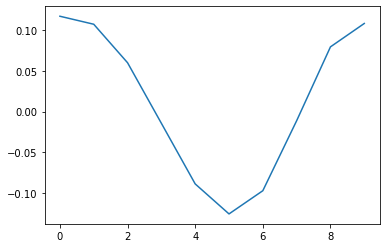

In [35]:
plt.plot(train_hps[0])

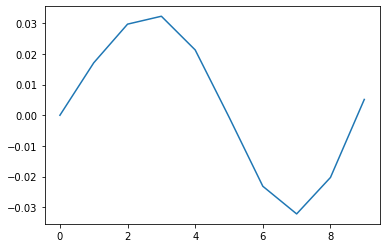

In [36]:
plt.plot(val_hcs[0])

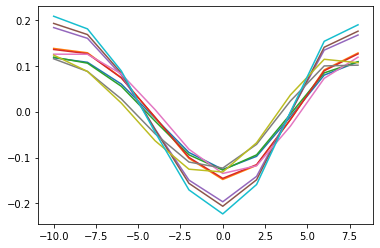

In [37]:
for i in range(10):
    plt.plot(train_times, train_hps[i])

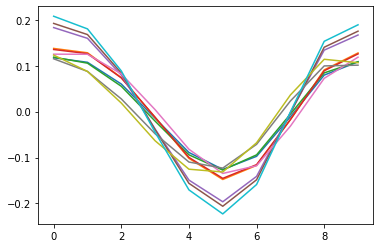

In [38]:
plt.figure()
for i in range(10):
    plt.plot(train_hps[i])

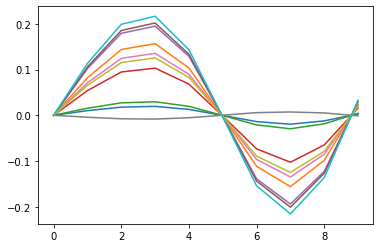

In [39]:
for i in range(10):
    plt.plot(train_hcs[i])

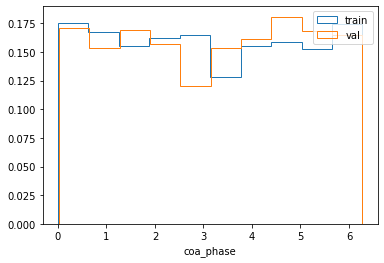

In [198]:
plt.figure()
plt.hist(train_thetas[:,0], density=True, histtype='step', label='train')
plt.hist(val_thetas[:,0], density=True, histtype='step', label='val')
plt.xlabel('coa_phase')
plt.legend()

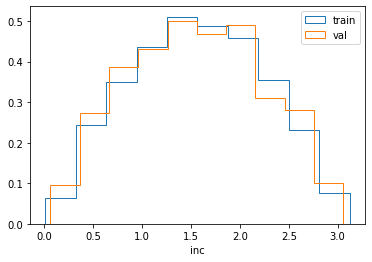

In [199]:
plt.figure()
plt.hist(train_thetas[:,1], density=True, histtype='step', label='train')
plt.hist(val_thetas[:,1], density=True, histtype='step', label='val')
plt.xlabel('inc')
plt.legend()

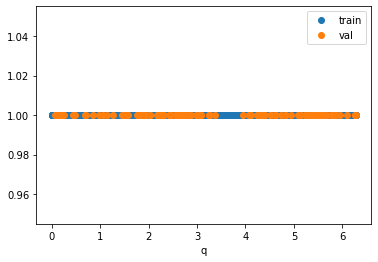

In [41]:
plt.figure()
plt.plot(train_thetas[:,0], np.ones(shape=(n_samples_train)), 'o', label='train')
plt.plot(val_thetas[:,0], np.ones(shape=(n_samples_val)), 'o', label='val')
plt.xlabel('q')
plt.legend()

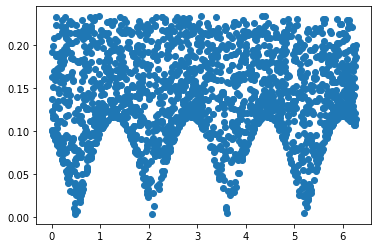

In [43]:
t_idx = 0
plt.figure()
plt.plot(train_thetas[:,0], train_hps[:,t_idx], 'o')

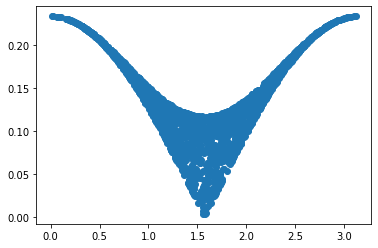

In [56]:
t_idx = 0
plt.figure()
plt.plot(train_thetas[:,1], train_hps[:,t_idx], 'o')

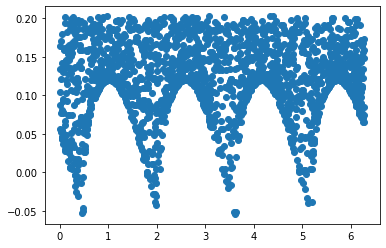

In [52]:
t_idx = 1
plt.figure()
plt.plot(train_thetas[:,0], train_hps[:,t_idx], 'o')

In [44]:
train_hps.shape

(2000, 10)

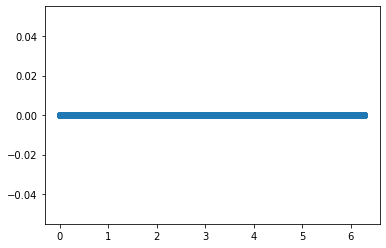

In [48]:
t_idx = 0
plt.figure()
plt.plot(train_thetas[:,0], train_hcs[:,t_idx], 'o')

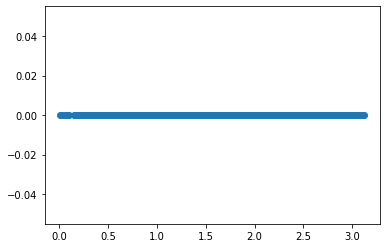

In [57]:
t_idx = 0
plt.figure()
plt.plot(train_thetas[:,1], train_hcs[:,t_idx], 'o')

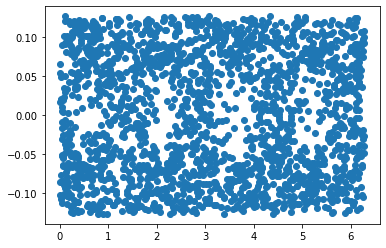

In [49]:
t_idx = 1
plt.figure()
plt.plot(train_thetas[:,0], train_hcs[:,t_idx], 'o')

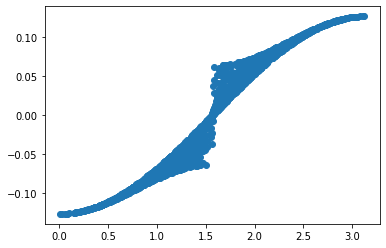

In [62]:
t_idx = 1
plt.figure()
plt.plot(train_thetas[:,1], train_hcs[:,t_idx], 'o')

# fit model

In [63]:
m1,m2 = pycbc.pnutils.mchirp_q_to_mass1_mass2(100, 8)
m1,m2

(356.52049159320063, 44.56506144915008)

time_b_scale: 0.0169
theta_b_scale: 1
theta_input_shape: 2
making traing dataset
making validation dataset
total_number_of_points (training): 20000
steps_per_epoch: 10000


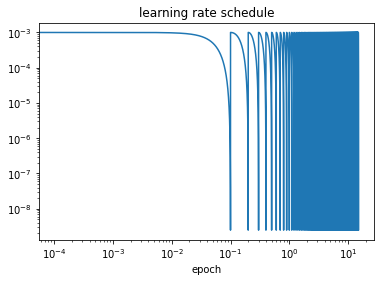

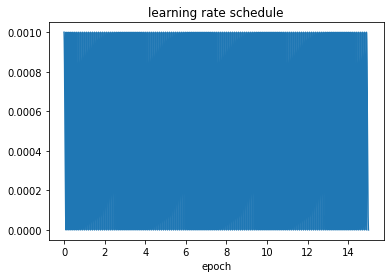

In [126]:
epochs = 15
#batch_size = 1024
# batch_size = 512
# batch_size = 128
# batch_size = 32
batch_size = 2

# f_rd_mf = waveform.HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=75, m2=25, s1z=0.99, s2z=0.99), 100)

f_rd_mf = waveform.HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=m1, m2=m2, s1z=0., s2z=0.), 100)

time_b_scale = np.around(f_rd_mf, 4)
print(f"time_b_scale: {time_b_scale}")

theta_b_scale = 1
# theta_b_scale = 10
# theta_b_scale = 0.5
# theta_b_scale = 100
# theta_b_scale = 0.1
# theta_b_scale = 0.01
# theta_b_scale = 0.001
print(f"theta_b_scale: {theta_b_scale}")

theta_input_shape = train_thetas.shape[1]
print(f"theta_input_shape: {theta_input_shape}")

print("making traing dataset")
train_ds = dataset.DataGen(thetas=train_thetas, times=train_times, ys=train_hps, batch_size=batch_size, shuffle=True)

# del train_thetas, train_times, train_hps

print("making validation dataset")
val_ds = dataset.DataGen(thetas=val_thetas, times=val_times, ys=val_hps, batch_size=batch_size, shuffle=False) 

# del val_thetas, val_times, val_hps

total_number_of_points = train_ds.total_number_of_points
print(f"total_number_of_points (training): {total_number_of_points}")



# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/10,
    # t_mul=2.0,
    t_mul=1.,
    m_mul=1.,
    alpha=0.0,
    name=None
)


step = np.arange(0, epochs * steps_per_epoch)
lr_ = lrs(step)

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()



In [127]:
checkpoint_filepath = './checkpoint_dir_demo-3D/checkpoint'

In [128]:
starttime = datetime.datetime.now()

history, model = model_utils.run_model_ds(
    train_ds=train_ds,
    time_b_scale=time_b_scale,
    theta_b_scale=theta_b_scale,
    theta_input_shape=theta_input_shape,
    epochs=epochs,
    threshold=1e-7,
    validation_data=val_ds,
    verbose=1,
    learning_rate=lrs,
    fan_in=128,
    n_layers=3,
    units=256,
    activation='relu',
    checkpoint_filepath=checkpoint_filepath
)

endtime = datetime.datetime.now()
duration = endtime - starttime
print(f"The time cost: {duration}")

Epoch 1/15
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0026 - val_loss: 1.8455e-04
Epoch 2/15
10000/10000 [==============================] - 33s 3ms/step - loss: 4.4051e-04 - val_loss: 1.2156e-04
Epoch 3/15
10000/10000 [==============================] - 32s 3ms/step - loss: 2.3011e-04 - val_loss: 6.8775e-05
Epoch 4/15
10000/10000 [==============================] - 32s 3ms/step - loss: 1.7697e-04 - val_loss: 4.8779e-05
Epoch 5/15
10000/10000 [==============================] - 32s 3ms/step - loss: 1.2928e-04 - val_loss: 3.4465e-05
Epoch 6/15
10000/10000 [==============================] - 32s 3ms/step - loss: 1.0110e-04 - val_loss: 3.2236e-05
Epoch 7/15
10000/10000 [==============================] - 32s 3ms/step - loss: 9.5059e-05 - val_loss: 2.9219e-05
Epoch 8/15
10000/10000 [==============================] - 32s 3ms/step - loss: 9.3911e-05 - val_loss: 2.6982e-05
Epoch 9/15
10000/10000 [==============================] - 32s 3ms/step - loss: 8.6456e-05 - val_loss

In [129]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_13 (Dense)               (None, 128)          384         ['theta_input[0][0]']            
                                                                                            

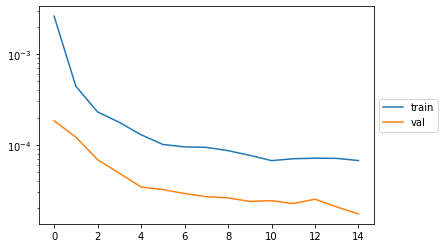

In [130]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# eval model

In [131]:
def build_input_single(t, *args):
    """
    t is a matrix i.e. shape = (-1, 1)
    list of parameters
    """
    theta = np.array([*args])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [132]:
def build_input_multiple(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single(t, *theta) for theta in thetas])

In [165]:
n_waveforms = val_thetas.shape[0]
n_times = val_times.shape[0]

In [166]:
Xval = build_input_multiple(val_times, val_thetas)

In [169]:
%%time
yhats_val = model([Xval[:,0], Xval[:,1:]])
yhats_val = yhats_val.numpy()
yhats_val = yhats_val.reshape(n_waveforms, n_times)

CPU times: user 285 ms, sys: 404 ms, total: 690 ms
Wall time: 38.1 ms


In [170]:
yhats_val.shape

(1000, 10)

In [171]:
mses = tf.keras.losses.mse(yhats_val, val_hps).numpy()

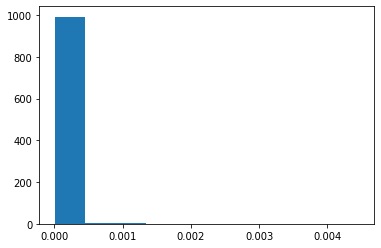

In [172]:
plt.hist(mses);

In [173]:
print(mses.min())
print(mses.max())
print(mses.mean())

1.2290868703273848e-06
0.004465242516286219
3.8110022591181393e-05


In [174]:
worst_index = mses.argmax()

In [175]:
val_thetas[worst_index]

array([3.68922848, 1.56066817])

In [176]:
#worst
plt.figure()
plt.plot(val_times, val_hps[worst_index])
plt.plot(val_times, yhats_val[worst_index])
# plt.xlim(-100, 100)

In [177]:
#worst
plt.figure()
plt.plot(val_times, val_hps[worst_index])
plt.plot(val_times, yhats_val[worst_index])
plt.xlim(-100, 100)

(-100.0, 100.0)

In [178]:
# best
plt.figure()
plt.plot(val_times, val_hps[mses.argmin()])
plt.plot(val_times, yhats_val[mses.argmin()])
# plt.xlim(-100, 100)

Text(0, 0.5, 'inc')

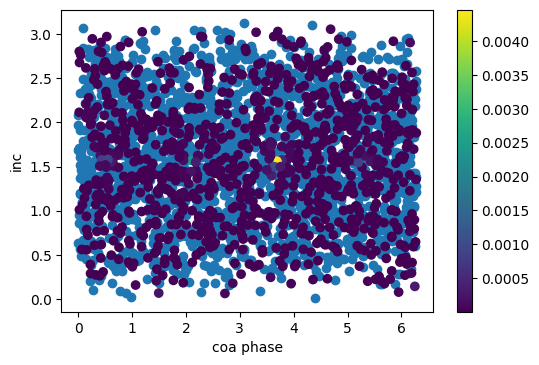

In [179]:
plt.figure(dpi=100)
plt.scatter(train_thetas[:,0], train_thetas[:,1])
plt.scatter(val_thetas[:,0], val_thetas[:,1], c=mses)
plt.colorbar()
plt.xlabel("coa phase")
plt.ylabel("inc")

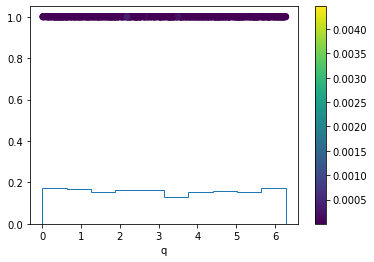

In [180]:
plt.figure()
plt.hist(train_thetas[:,0], density=True, histtype='step')
plt.scatter(val_thetas[:,0], np.ones(shape=(n_samples_val)), c=mses)
plt.xlabel('q')
plt.colorbar()

In [181]:
# undo sign flip
# yhats_val[mask_val_inc_pi2] = -yhats_val[mask_val_inc_pi2]

In [182]:
for yhat_val in yhats_val[:10]:
    plt.plot(val_times, yhat_val)

In [183]:
df_mse = pd.DataFrame({'mse':mses})

In [184]:
idxs = df_mse[df_mse['mse'] > np.percentile(mses,90)].index

In [185]:
df_mse.iloc[idxs]

mse
5    0.000052
6    0.002284
7    0.000123
9    0.000101
11   0.000113
..        ...
896  0.000112
939  0.000375
943  0.000058
964  0.000101
990  0.000198

[100 rows x 1 columns]

/home/sebastian.khan/.conda/envs/tf2/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


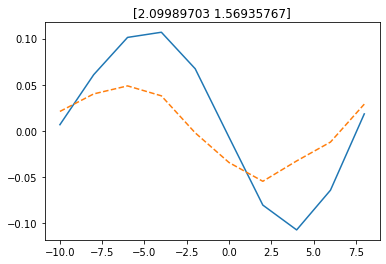

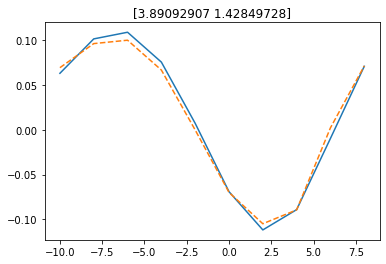

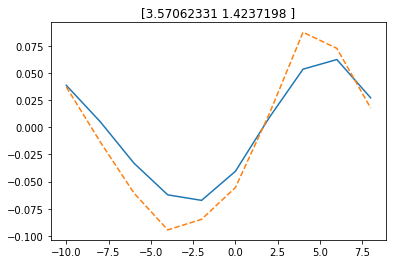

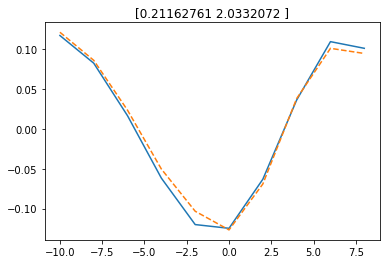

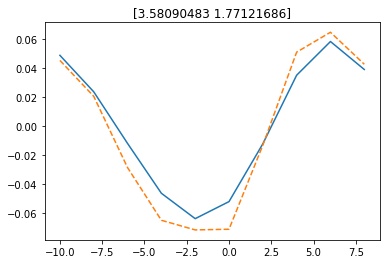

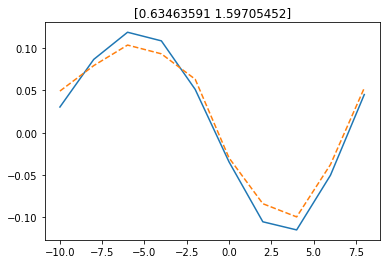

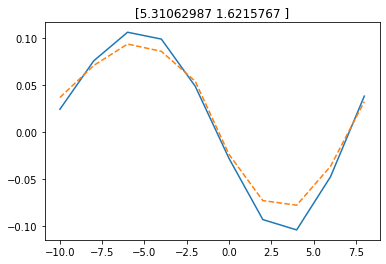

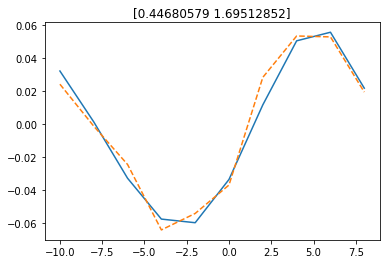

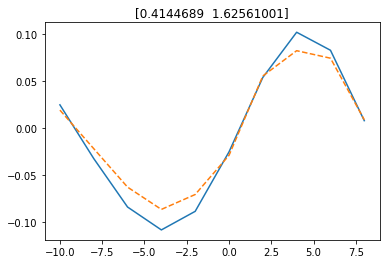

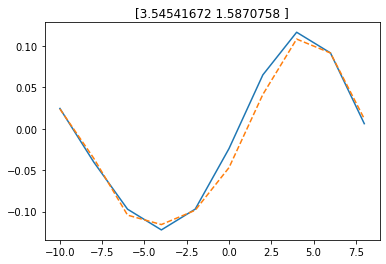

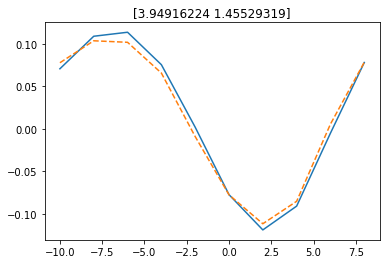

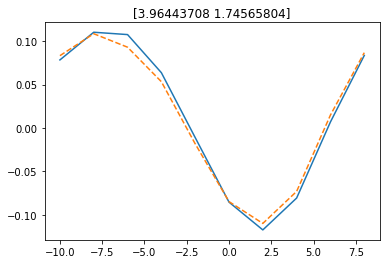

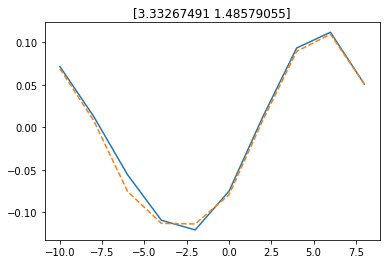

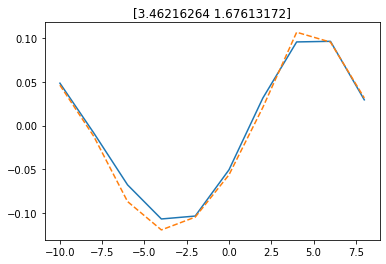

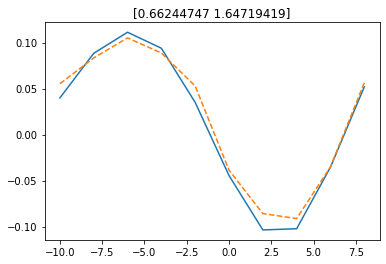

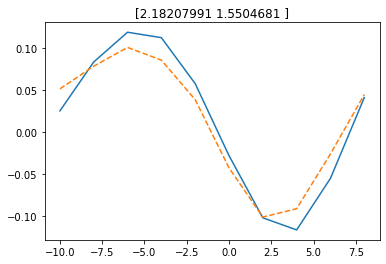

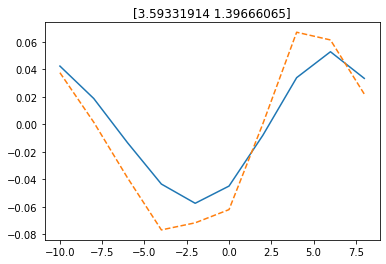

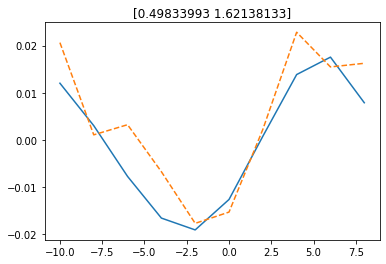

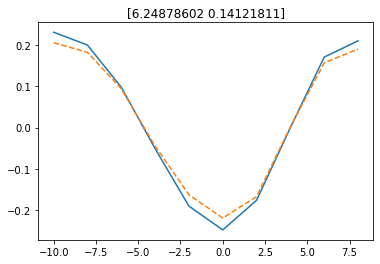

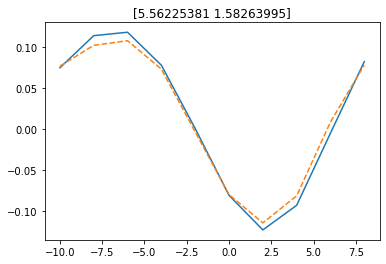

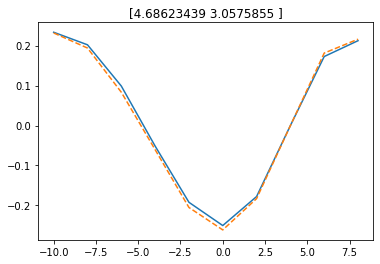

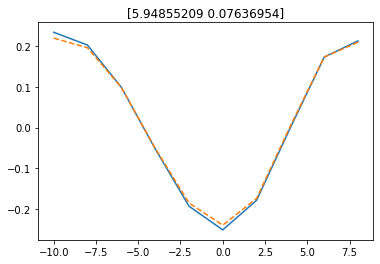

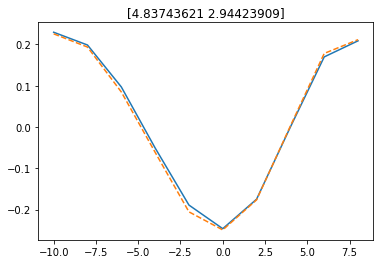

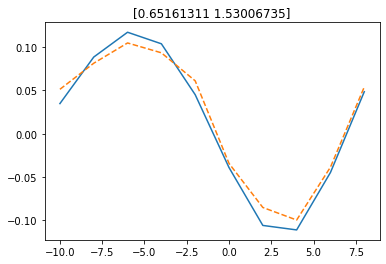

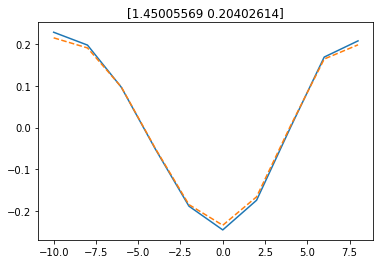

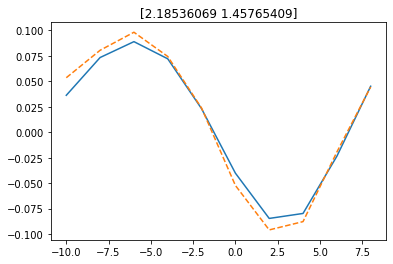

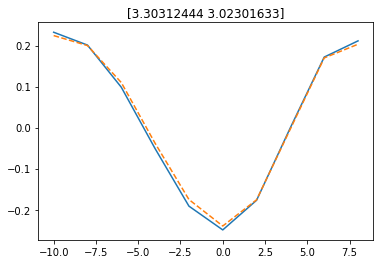

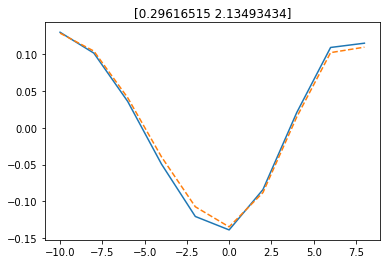

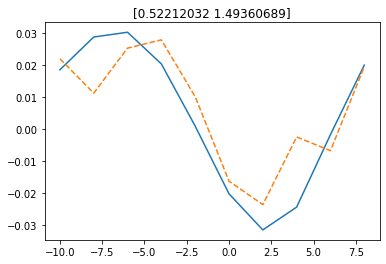

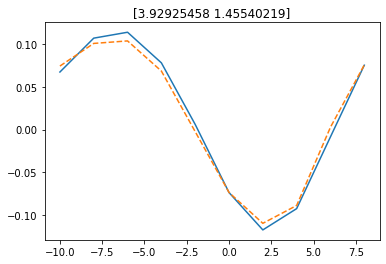

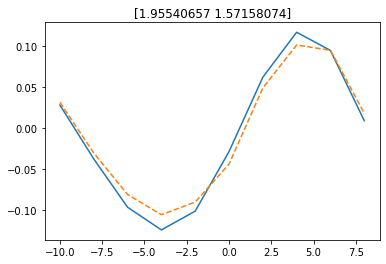

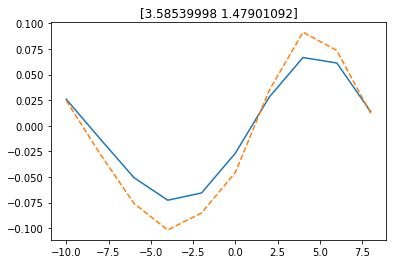

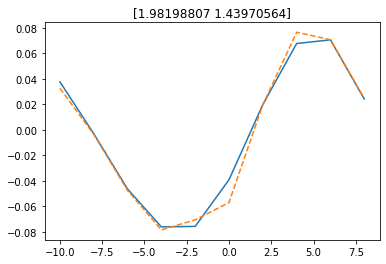

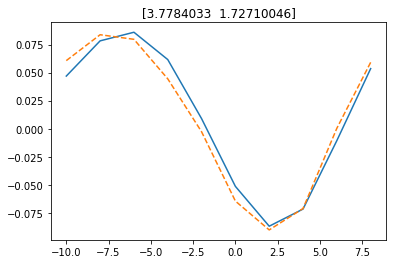

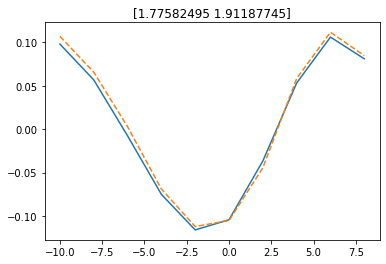

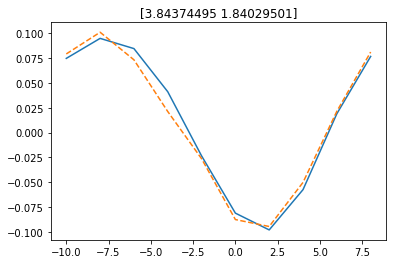

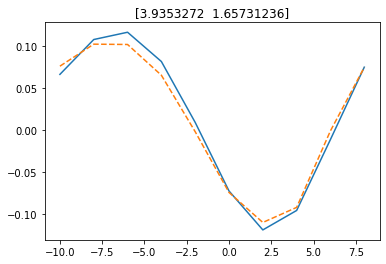

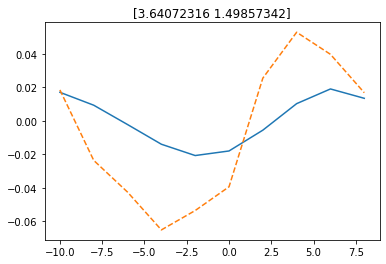

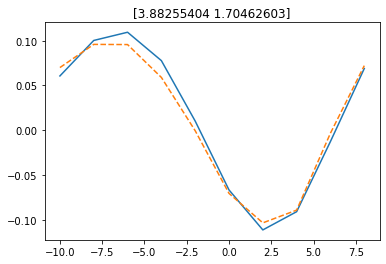

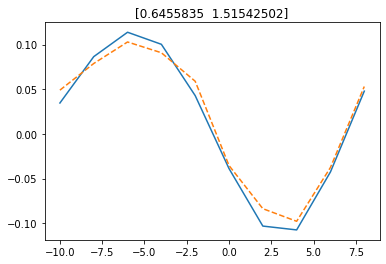

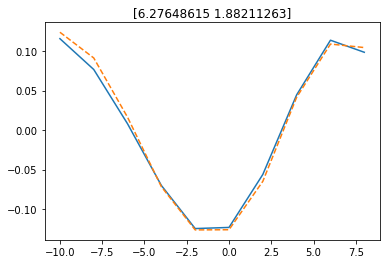

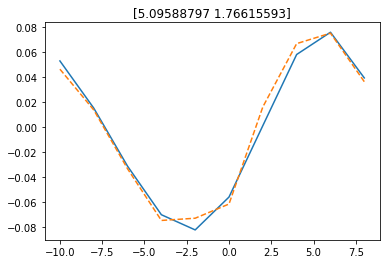

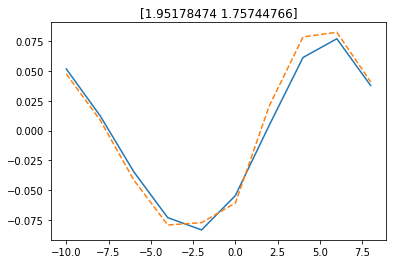

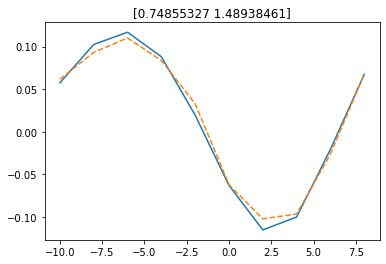

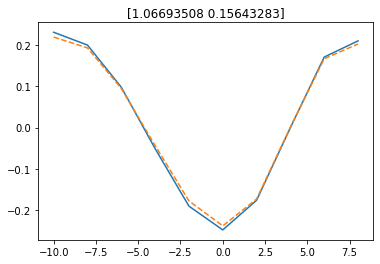

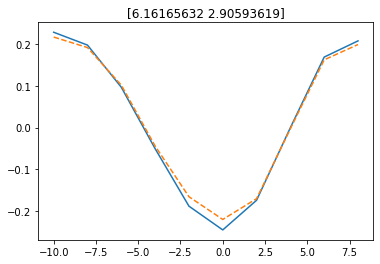

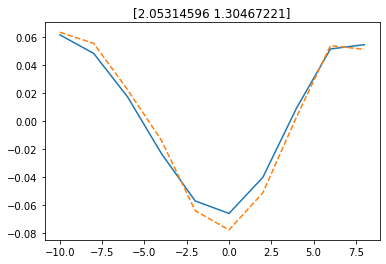

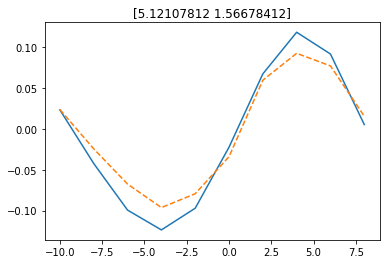

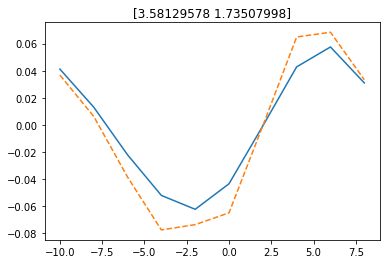

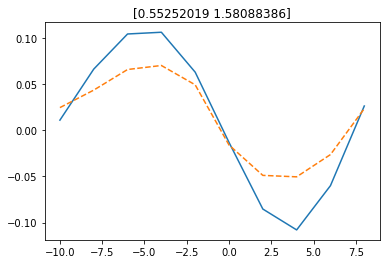

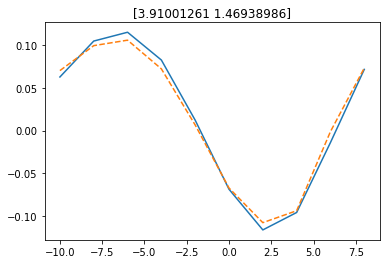

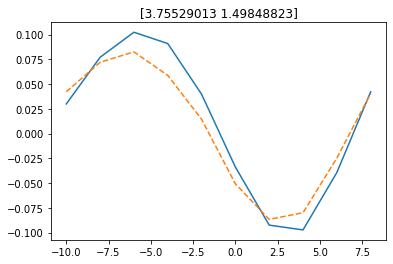

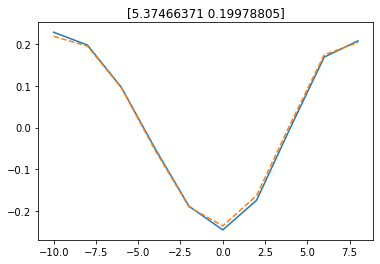

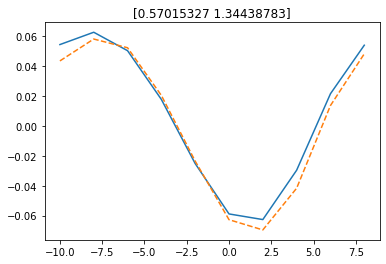

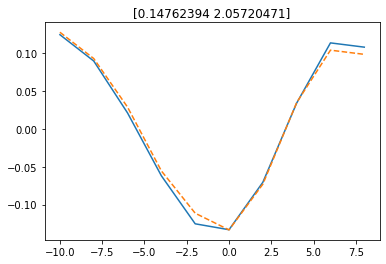

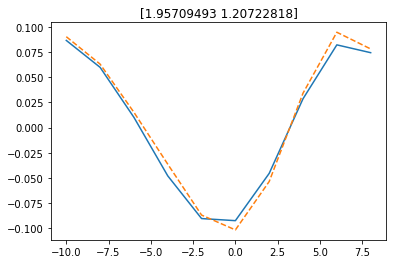

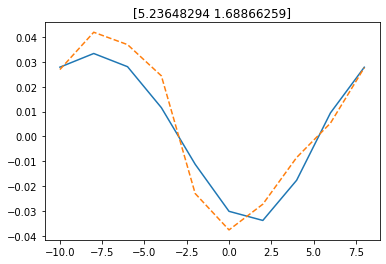

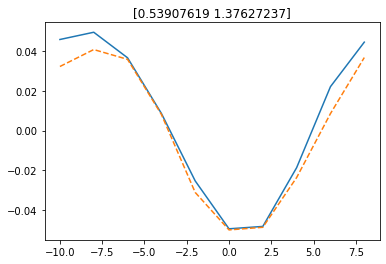

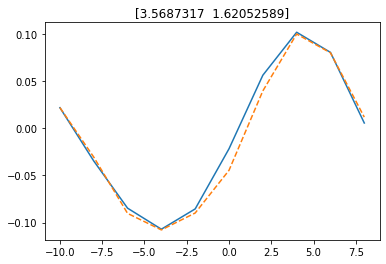

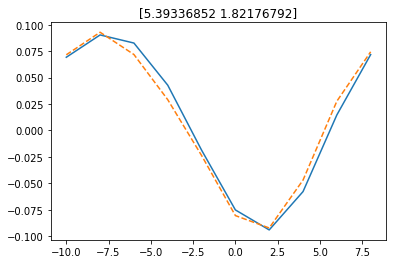

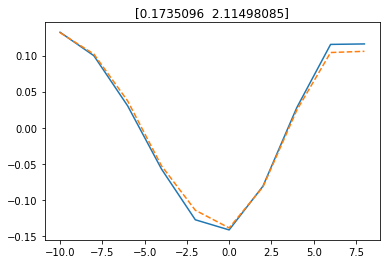

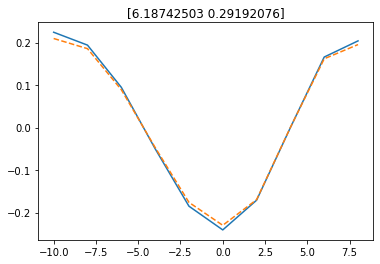

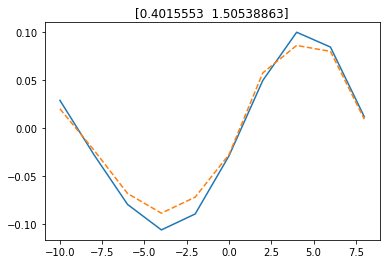

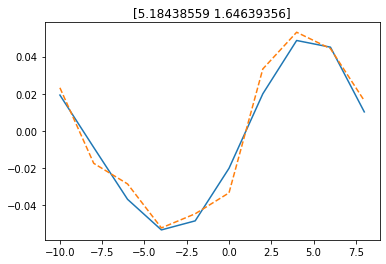

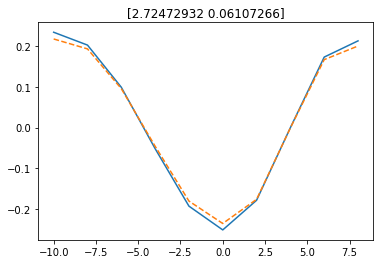

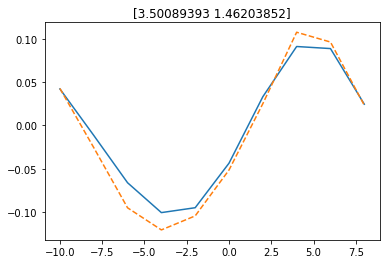

In [186]:
for i in idxs:
    plt.figure()
    plt.plot(val_times, val_hps[i])
    plt.plot(val_times, yhats_val[i], ls='--')
    plt.title(val_thetas[i])
    plt.show()
    plt.close()

In [187]:
t_idx = 0
print(f"t = {val_times[t_idx,0]}")

df1=pd.DataFrame({'th':val_thetas[:,0], 'h':val_hps[:,t_idx]})
df1=df1.sort_values(by='th')

df2=pd.DataFrame({'th':val_thetas[:,0], 'h':yhats_val[:,t_idx]})
df2=df2.sort_values(by='th')

plt.figure()
plt.plot(df1['th'], df1['h'], 'o-')
plt.plot(df2['th'], df2['h'], 'o--', mfc='none')

t = -10.0


In [188]:
t_idx = 1
print(f"t = {val_times[t_idx,0]}")

df1=pd.DataFrame({'th':val_thetas[:,0], 'h':val_hps[:,t_idx]})
df1=df1.sort_values(by='th')

df2=pd.DataFrame({'th':val_thetas[:,0], 'h':yhats_val[:,t_idx]})
df2=df2.sort_values(by='th')

plt.figure()
plt.plot(df1['th'], df1['h'], 'o-')
plt.plot(df2['th'], df2['h'], 'o--', mfc='none')

t = -8.0


t = 8.0


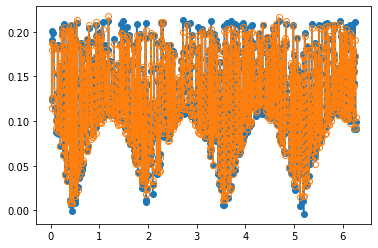

In [189]:
t_idx = -1
print(f"t = {val_times[t_idx,0]}")

df1=pd.DataFrame({'th':val_thetas[:,0], 'h':val_hps[:,t_idx]})
df1=df1.sort_values(by='th')

df2=pd.DataFrame({'th':val_thetas[:,0], 'h':yhats_val[:,t_idx]})
df2=df2.sort_values(by='th')

plt.figure()
plt.plot(df1['th'], df1['h'], 'o-')
plt.plot(df2['th'], df2['h'], 'o--', mfc='none')

In [191]:
t_idx = -1
print(f"t = {val_times[t_idx,0]}")

df1=pd.DataFrame({'th':val_thetas[:,0], 'h':val_hps[:,t_idx]})
df1=df1.sort_values(by='th')

df2=pd.DataFrame({'th':val_thetas[:,0], 'h':yhats_val[:,t_idx]})
df2=df2.sort_values(by='th')

plt.figure()
plt.plot(df1['th'], df1['h'], 'o-')
plt.plot(df2['th'], df2['h'], 'o--', mfc='none')
plt.xlim(0, 1)

t = 8.0


(0.0, 1.0)

In [197]:
t_idx = 0
print(f"t = {val_times[t_idx,0]}")

df1=pd.DataFrame({'th':val_thetas[:,1], 'h':val_hps[:,t_idx]})
df1=df1.sort_values(by='th')

df2=pd.DataFrame({'th':val_thetas[:,1], 'h':yhats_val[:,t_idx]})
df2=df2.sort_values(by='th')

plt.figure()
plt.plot(df1['th'], df1['h'], 'o-')
plt.plot(df2['th'], df2['h'], 'o--', mfc='none')
# plt.xlim(1, 1.6)

t = -10.0


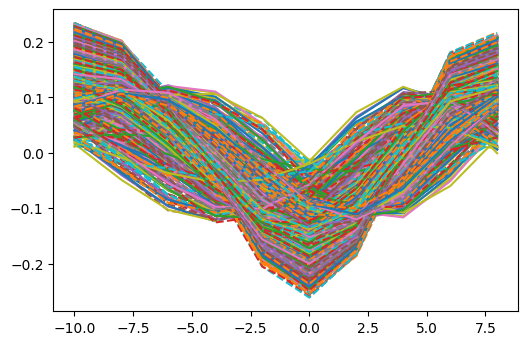

In [190]:
plt.figure(dpi=100)
for i in range(n_samples_val):
    if val_thetas[i,1] > np.pi/2:
        plt.plot(val_times, val_hps[i])
        plt.plot(val_times, yhats_val[i], ls='--')